## Connecting to database. 
#### Sqlite3 to connect with database.db file and pandas to grab data.

In [1]:
import pandas as pd
import sqlite3

#### Connecting to database and geting table names.

In [2]:
conn = sqlite3.connect("database.db")
cur = conn.cursor()
res = cur.execute("select * from sqlite_master where type='table'") 

#### With executing: 
```python 
    print(list(res))
```
#### we can get table names and information about keys reference.

In [3]:
print(list(res))

[('table', 'data', 'data', 2, 'CREATE TABLE data (\n    id INTEGER PRIMARY KEY,\n    x REAL,\n    y TEXT,\n    z REAL,\n    connection_id INTEGER,\n    FOREIGN KEY(connection_id) REFERENCES connection(id)\n)'), ('table', 'connection', 'connection', 3, 'CREATE TABLE connection (\n    id INTEGER PRIMARY KEY,\n    name TEXT\n)'), ('table', 'additional_data', 'additional_data', 4, 'CREATE TABLE additional_data (\n    color_id INTEGER PRIMARY KEY,\n    color_name TEXT\n)')]


## Let's grab tables from database!

In [4]:
data = pd.read_sql("SELECT * FROM data",conn)
connection = pd.read_sql("SELECT * FROM connection",conn)
additional_data = pd.read_sql("SELECT * FROM additional_data",conn)

#### Take a look at tables.

In [5]:
data = data.set_index('id')
data

,x,y,z,connection_id
id,,,,
1,44.628947,97.81099110033537,569.700453,105
2,40.764309,82.0486367746882,653.904064,76
3,25.849509,63.29510234435348,374.171176,72
4,18.973396,50.59596955801666,440.976635,239
5,44.787622,39.347747208411256,219.388963,152
...,...,...,...,...
101296,1.851515,84.17753890986283,409.281547,203
101297,96.653658,89.89605659969567,172.548292,152
101298,21.920406,2.6404943806156767,176.266498,76


In [6]:
connection = connection.set_index('id')
connection.head()

,name
id,
2,blue
4,blue
9,blue
10,blue
15,blue


In [7]:
additional_data

,color_id,color_name
0,0,red
1,2,blue
2,3,yellow
3,4,orange
4,5,black
5,11,green


## Putting all data to one DataFrame.

In [8]:
df = data.merge(connection,how='left',left_on='connection_id',right_index=True)
df = df.merge(additional_data,how='inner',left_on='name',right_on='color_name')

#### Ensuring that values types are correct.

In [9]:
df['x'] = pd.to_numeric(df['x'])
df['y'] = pd.to_numeric(df['y'])
df['z'] = pd.to_numeric(df['z'])
df['color_id'] = pd.to_numeric(df['color_id'])

#### A few more drops...

In [10]:
df = df.drop(['name', 'connection_id'],axis=1)
df = df.dropna()
df.columns = ['x', 'y', 'z', 'color_id', 'color']
df

,x,y,z,color_id,color
0,44.628947,97.810991,569.700453,11,green
1,81.428951,56.675770,30.014223,11,green
2,53.401394,78.058615,291.489162,11,green
3,83.253902,20.349643,835.796016,11,green
4,50.463208,8.814925,492.720476,11,green
...,...,...,...,...,...
101195,24.094444,9.729351,794.632509,2,blue
101196,28.785665,39.273730,251.549429,2,blue
101197,59.562938,28.327138,881.214007,2,blue
101198,56.013233,47.271806,370.917873,2,blue


#### Finding unique values in ```color``` column.

In [11]:
unique_color = df['color'].unique()
unique_color

array(['green', 'orange', 'yellow', 'red', 'black', 'blue'], dtype=object)

## Beginning of preparation to plot Mr. Smile.

#### Here we are dropping everything, but those with ```z = 100```.

In [12]:
df = df.where(df['z'] == 100).dropna()

#### Creating function to grab indexes of red points that with bigger distance from "avrage red point" then sigma.
(By the way, I didn't know what is sigma value. So I start experimenting with it. After all I found 0.5 is ok value. Hope it didn't cover any mistakes.)

In [13]:
sigma = 0.5

In [14]:
import numpy as np

def avrg_red(df,sigma):
    
    # Prepering DataFrame with red points
    reds = df[['x','y','z']].where(df['color'] == 'red').dropna()
    
    # Calculating "avrage red point" (ARP)
    avrg = reds[['x','y','z']].mean(axis=0).values
    print(avrg)
    #Calculating distance from ARP for each point
    reds['dist'] = np.linalg.norm(reds[['x','y','z']].values - avrg, axis=1)

    # Collecting indexes of points that are closer from ARP then sigma
    indexes = reds.where(reds['dist'] > sigma).dropna().index
    
    return indexes

#### Here we call out ```avrg_red``` method and drop red points.

In [15]:
indexes = avrg_red(df,sigma)

df = df.drop(index=indexes)
df

[-1.00000000e+00  4.34671281e-02  1.00000000e+02]


,x,y,z,color_id,color
86,1.127273,0.052112,100.0,11.0,green
164,0.884848,0.005364,100.0,11.0,green
655,0.880808,0.007759,100.0,11.0,green
693,0.828283,0.007381,100.0,11.0,green
881,0.840404,0.044705,100.0,11.0,green
...,...,...,...,...,...
101155,0.642643,-0.399358,100.0,2.0,blue
101160,1.555556,-0.267015,100.0,2.0,blue
101177,0.314314,-0.469043,100.0,2.0,blue
101182,1.559560,-0.258990,100.0,2.0,blue


#### Now we set correct indexes.

In [16]:
df.index = np.arange(0, len(df))
df

,x,y,z,color_id,color
0,1.127273,0.052112,100.0,11.0,green
1,0.884848,0.005364,100.0,11.0,green
2,0.880808,0.007759,100.0,11.0,green
3,0.828283,0.007381,100.0,11.0,green
4,0.840404,0.044705,100.0,11.0,green
...,...,...,...,...,...
1195,0.642643,-0.399358,100.0,2.0,blue
1196,1.555556,-0.267015,100.0,2.0,blue
1197,0.314314,-0.469043,100.0,2.0,blue
1198,1.559560,-0.258990,100.0,2.0,blue


#### Saving it to HDF5 file.

In [17]:
ns1 = df.drop(columns=['z','color_id'])
ns1.to_hdf('ns1.h5',key='ns1')

#### And at the end we are ploting Mr. Smile :)

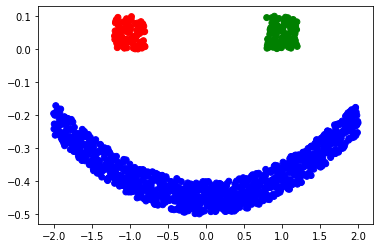

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.scatter(pd.read_hdf('ns1.h5',key='ns1').values[:,0],
            pd.read_hdf('ns1.h5',key='ns1').values[:,1],
            c=pd.read_hdf('ns1.h5',key='ns1').values[:,2])